In [36]:
from astropy.table import Table
import matplotlib.pyplot as plt
import wotan
import numpy as np
import pandas as pd
from scipy import stats

%matplotlib inline

In [37]:
from get_threshold import get_threshold

In [38]:
with open("../data/all_systems.txt") as f:
    all_systems = f.read().split(",")

In [39]:
system_id = all_systems[4] # We're building this around 19, for now
system_id

'kplr001433410.fits'

In [40]:
df = Table.to_pandas(Table.read("../data/combined/" + system_id, format="fits"))
# Note that you can't just shove table data into a dataframe
# This is because the endianess changes. Use the .to_pandas() function
df = df.dropna(how="any")
df.columns = ("time", "flux")
df["flux"] = wotan.flatten(df["time"], df["flux"], window_length=0.5, method='biweight')
df.head()

,time,flux
0,1274.140307,0.917498
1,1274.160741,0.990148
2,1274.181176,1.034283
3,1274.201610,1.047836
4,1274.222044,1.036900


In [41]:
df["previous"] = df["flux"].shift(periods=1)
df.head()

,time,flux,previous
0,1274.140307,0.917498,NaN
1,1274.160741,0.990148,0.917498
2,1274.181176,1.034283,0.990148
3,1274.201610,1.047836,1.034283
4,1274.222044,1.036900,1.047836


In [42]:
threshold = get_threshold(df["flux"].median(), df["flux"].std())
df["descending"] = (df["flux"] < threshold) & (df["previous"] > threshold)
df["ascending"] = (df["flux"] > threshold) & (df["previous"] < threshold)

In [43]:
threshold

0.9414310411054249

In [44]:
crossings = df[df["descending"] | df["ascending"]]
crossings  # As one may expect, "crossings" is a dataframe of all points where the light curve crosses the threshold

,time,flux,previous,descending,ascending
1,1274.160741,0.990148,0.917498,False,True
6,1274.262913,0.937805,1.002991,True,False
8,1274.303782,0.996733,0.930111,False,True
13,1274.405954,0.926379,0.995233,True,False
15,1274.446823,0.995707,0.926633,False,True
...,...,...,...,...,...
9523,1470.870459,0.911938,0.955356,True,False
9524,1470.890891,0.972662,0.911938,False,True
9530,1471.013489,0.906958,0.942036,True,False
9531,1471.033922,0.966698,0.906958,False,True


In [45]:
if crossings.iloc[0,4]:
    crossings = crossings[1:]
    # An eclipse has to start from somewhere
crossings.head()

,time,flux,previous,descending,ascending
6,1274.262913,0.937805,1.002991,True,False
8,1274.303782,0.996733,0.930111,False,True
13,1274.405954,0.926379,0.995233,True,False
15,1274.446823,0.995707,0.926633,False,True
20,1274.548994,0.925948,0.996361,True,False


In [46]:
crossings.reset_index(drop=False, inplace=True)
crossings.head()

,index,time,flux,previous,descending,ascending
0,6,1274.262913,0.937805,1.002991,True,False
1,8,1274.303782,0.996733,0.930111,False,True
2,13,1274.405954,0.926379,0.995233,True,False
3,15,1274.446823,0.995707,0.926633,False,True
4,20,1274.548994,0.925948,0.996361,True,False


In [47]:
eclipses = pd.DataFrame()
eclipses["time"] = crossings["time"].rolling(window=pd.api.indexers.FixedForwardWindowIndexer(window_size=2)).mean()
eclipses = eclipses.iloc[::2]
eclipses.head()

,time
0,1274.283348
2,1274.426388
4,1274.569429
6,1274.712469
8,1274.865727


In [48]:
eclipses["duration"] = (crossings["time"].shift(periods=-1) - crossings["time"])[::2]
eclipses.head()
# These are the durations, and only here in case we want to drop extremely long eclipses as anomalies

,time,duration
0,1274.283348,0.040869
2,1274.426388,0.040869
4,1274.569429,0.040869
6,1274.712469,0.040869
8,1274.865727,0.020434


In [49]:
eclipses["diff"] = eclipses["time"].shift(periods=-1) - eclipses["time"]
eclipses.head()

,time,duration,diff
0,1274.283348,0.040869,0.143041
2,1274.426388,0.040869,0.143041
4,1274.569429,0.040869,0.143041
6,1274.712469,0.040869,0.153258
8,1274.865727,0.020434,0.132823


In [50]:
def remove_extremes(arr, col):
    std = stats.mstats.trimmed_std(arr[col])
    # Here, the trimmed std is used to get the std of the central 80%, because
    # otherwise outliers skew the data to include themselves
    median = np.nanmedian(arr[col])

    thresh_lower = median - 4 * std
    thresh_upper = median + 4 * std
    print(str(((arr[col] > thresh_upper) | (arr[col] < thresh_lower)).sum()) + " eclipses dropped")
    return arr[(arr[col] < thresh_upper) & (arr[col] > thresh_lower)]

In [51]:
eclipses = remove_extremes(eclipses, "diff")

15 eclipses dropped


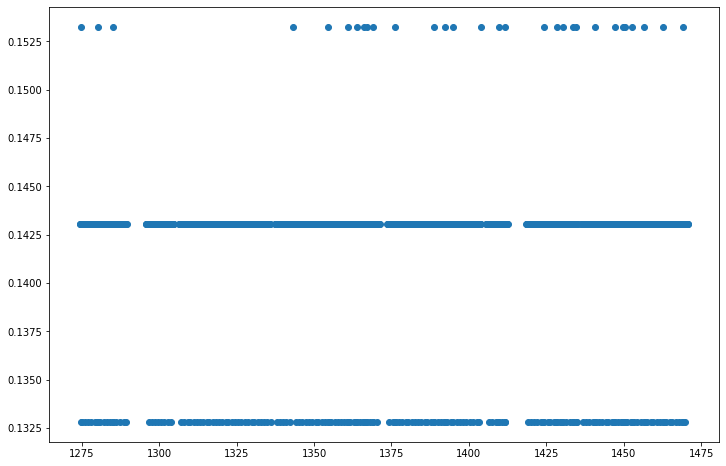

In [53]:
plt.figure(figsize=(12, 8))
plt.scatter(x=eclipses["time"], y=eclipses["diff"])
# plt.show()